<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Blob analytical scaling law based on tracking (Script 6_0)</b></span><br>
<span style="font-size: 16px;">
- In this script, we apply the analytical scaling laws derived in the past litteratures. <br>
- There are two existing models for this:<br>
- (1) One makes use of Lambda and Theta<br>
- (2) The other makes use of hat-a and hat-v. 
</span>
</div>



In [1]:
import sys
sys.path.append('/marconi/home/userexternal/klim0000/my_venv/lib/python3.9/site-packages')
#from skimage.measure import label, regionprops

In [2]:
sys.path.append('/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy/blobs/Devel')
sys.path.append('/marconi/home/userexternal/klim0000/my_venv/lib/python3.9/site-packages')
sys.path.append('/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy/blobs')
#from Blob_detection import *
#from CBlob_plots import *
#from Filament_utils import *
#from CBlobs import *

In [3]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
import matplotlib.colors as mcolors

from skimage import measure

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
from gbspy.blobs import *

In [5]:
#import sys  
#sys.path.insert(0, '/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')

# Get the current working directory|
cwd = os.getcwd()

# PT
os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DPT_d0p6')

#NT
#os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()

Current working directory: /marconi/home/userexternal/klim0000/jupyter_notebook/3_GBS_DN_Tria


In [6]:
t2= s.time[-1]
t1= t2 - 0.1

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]


dens         = s.get_field('n', z1=z1, z2=z2, t1=t1, t2=t2)
dens_avg     = np.mean(dens, axis=(2,3)); 
dens_avg_tor = np.mean(dens, axis=2)
dens_std     = np.std(dens, axis=(2,3))

Te  = s.get_field('Te', z1=z1, z2=z2, t1=t1, t2=t2)
Te_avg  = np.mean(Te, axis=(2,3)); 
Te_avg_tor = np.mean(Te, axis=2)

pe = dens * Te
pe_avg = np.mean(pe, axis=(2,3))
pe_std = np.std(pe, axis=(2,3))

Ti  = s.get_field('Ti', z1=z1, z2=z2, t1=t1, t2=t2)
Ti_avg  = np.mean(Ti, axis=(2,3)); 
Ti_avg_tor = np.mean(Ti, axis=2)

phi = s.get_field('strmf', z1=z1, z2=z2, t1=t1, t2=t2)
phi_x = np.gradient(phi, axis=1)
phi_y = np.gradient(phi, axis=0)


# Normalized
dens_fluct   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
#dens_fluct = dens[:,:,0,-1] - dens_avg
dens_fluct_avg = np.mean(dens_fluct, axis=2)

In [7]:
FilamentList = filament_main(s, 'n', dens_avg, dens_std, t1=t1, t2=t2, mask=None, threshold=2.5, inter_tol=0.3, len_tol=100,
             age_tol=0, ExBvel = True, hole=False, output_name='test')

/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy/blobs/Filament_utils.py:312: RuntimeWarning: invalid value encountered in divide
  return (data - avg4D) / std4D


Detection in step 1/2 done
Detection in step 2/2 done
0 merging events detected
0 splitting events detected
Detected 14 filaments in total
14 survived more than 0 steps
Detection done in 3.13 s
Finished setting attributes of filaments for timestep 0/1
in  7.81 s
Finished setting attributes of filaments for timestep 1/1
in  6.55 s


In [ ]:
Lambdas = [fil.Lambda for fil in FilamentList]

In [ ]:
[dens, dens_mean, dens_std] = compute_mean_std(s, 'n', t1=t1, t2=t2)


In [ ]:
Bloblist = blob_detection(s, n=dens, MEAN=dens_mean, STD=dens_std, t1=t1, t2=t2)

In [ ]:
Bloblist

In [ ]:
CBlob
#set_attributes(s, dens, Te, Ti, Phi_y, Xpsi, Ypsi, L1, L2)

In [ ]:
mask = np.zeros((s.ny, s.nx))

Bloblist=cblob_main(s, dens, dens_avg, dens_std, mask, Te_avg, Ti_avg, phi_y, Xpsi, Ypsi,
                    t1=t1, t2=t2, L1, L2, threshold = 2.5, inter_tol = 0.8, itime_tol = 3)


# Build grid

In [ ]:
#Xpsi, Ypsi, rpsi, chi, dchi = build_grid(s, 0.7, 0.8, Nchi=200)
from gbspy.utils import intersection
from scipy.interpolate import RectBivariateSpline


rmin=0.9; rmax=0.91; Nchi=200
def build_grid(s, rmin, rmax, Nchi=200):
    X, Y = np.meshgrid(s.x, s.y)
    Xcoord = {}
    Ycoord = {}
    rpsi = []

    if(rmax <= 1): 
        ix_min = s.find_ind(s.x0 + rmin*s.rminor, s.x)
        ix_max = s.find_ind(s.x0 + rmax*s.rminor, s.x)
        iy0 = s.find_ind(s.y0, s.y)
        ix = np.arange(ix_min, ix_max, 1)
        Nr = ix.shape[0]
        plt.figure(dpi=50)
        for i in ix: 
            cs = plt.contour(X, Y, s.Psi, levels=[s.Psi[iy0, i]])
            #p0  =cs.collections[0].get_paths()[0] # Lower
            #p1  =cs.collections[0].get_paths()[1] # Upper
            #p2  = cs.collections[0].get_paths()[2] # Center
            p = cs.collections[0].get_paths()[2]
            v = p.vertices
            Xcoord[i] = v[:, 0]
            Ycoord[i] = v[:, 1]
            rtmp, _ = intersection(np.array([s.x0, s.xmax]),
                                   np.array([s.y0, s.y0]),
                                   Xcoord[i], Ycoord[i])
            rpsi.append((rtmp[0] - s.x0)/s.rminor)
        plt.close()
        alpha = [-2*np.pi*i/Nchi for i in range(0, Nchi)]
        rtmp = np.array([1, 2*s.rminor])
        Xint = []
        Yint = []
        for al in alpha:
            xtmp = rtmp * np.cos(al) + s.x0
            ytmp = rtmp * np.sin(al) + s.y0
            xx, yy = intersection(Xcoord[ix[0]], Ycoord[ix[0]], xtmp, ytmp)
            Xint.append(xx[0])
            Yint.append(yy[0])


    if(rmin >= 1):
        if(rmin == 1):
            ix_min = s.find_ind(s.x0 + s.rminor, s.x) + 1
        else:
            ix_min = s.find_ind(s.x0 + rmin * s.rminor, s.x)
        ix_max = s.find_ind(rmax*s.rminor + s.x0, s.x)
        iy0 = s.find_ind(s.y0, s.y)
        ix_min = s.find_ind(s.Psi[iy0, ix_min],
                            s.Psi[s.iyxpt, s.ixxpt:]) + s.ixxpt
        ix_max = s.find_ind(s.Psi[iy0, ix_max],
                            s.Psi[s.iyxpt, s.ixxpt:]) + s.ixxpt

        if(rmin == rmax):
            ix_min = ix_max
        ix = np.arange(ix_min, ix_max, 1)
        Nr = ix.shape[0]
        rpsi = []
        plt.figure(dpi=50)
        for ind, i in enumerate(ix):
            cs = plt.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, i]])
            p = cs.collections[0].get_paths()[0]
            v = p.vertices
            rtmp, _ = intersection(np.array([s.x0, s.xmax]),
                                   np.array([s.y0, s.y0]),
                                   v[:, 0], v[:, 1])

            try:
                rpsi.append((rtmp[0] - s.x0)/s.rminor)
            except IndexError:
                print('rmax set to ', rpsi[-1])
                Nr = len(ix[:ind])
                break

            Xcoord[i] = v[:, 0]
            Ycoord[i] = v[:, 1]

        plt.close()
        Xint = []
        Yint = []
        Xint.append(Xcoord[ix[0]][0])
        Yint.append(Ycoord[ix[0]][0])
        alpha = np.linspace(0, 2*np.pi, 100)
        rcirc = np.sqrt(s.dx**2 + s.dy**2)*2
        i = 0
        while 1:
            if (np.abs(Yint[i] - Ycoord[ix[0]][-1]) <= rcirc and np.abs(
                    Xint[i] - Xcoord[ix[0]][-1]) <= rcirc and i > 1):
                break
            xtmp = Xint[i] + rcirc*np.cos(alpha)
            ytmp = Yint[i] + rcirc*np.sin(alpha)
            xx, yy = intersection(Xcoord[ix[0]],
                                  Ycoord[ix[0]],
                                  xtmp,
                                  ytmp)
            if ((i > 0) and np.abs(
                    Xint[i-1] - xx[0]) < rcirc and np.abs(
                        Yint[i-1] - yy[0]) < rcirc):
                Xint.append(xx[1])
                Yint.append(yy[1])
            else:
                Xint.append(xx[0])
                Yint.append(yy[0])
            i = i + 1

    try:
        dpsidx = s.dpsidx_v
        dpsidy = s.dpsidy_v
    except AttributeError:
        dpsidx = np.zeros(s.Psi.shape)
        dpsidy = np.zeros(s.Psi.shape)
        dpsidx[:, 1:] = np.diff(s.Psi, 1, axis=1)/s.dx
        dpsidy[1:, :] = np.diff(s.Psi, 1, axis=0)/s.dy

    dpsidx_int = RectBivariateSpline(s.y, s.x, dpsidx)
    dpsidy_int = RectBivariateSpline(s.y, s.x, dpsidy)

    if(rmin >= 1):
        Ns = 4
        Np = len(Xint) - 4
    else:
        Ns = 0
        Np = len(Xint)
    Nt = Np - Ns

    Xpsi = np.empty([Nr, Nt])
    Ypsi = np.empty([Nr, Nt])
    Xpsi[0, :] = Xint[Ns:Np]
    Ypsi[0, :] = Yint[Ns:Np]
    chi = np.zeros([Nr, Nt])
    dchi = np.zeros([Nr, Nt])
    for j in range(1, Nt):
        dchi[0, j] = np.sqrt((Xint[j-1] - Xint[j])**2 +
                             (Yint[j-1] - Yint[j])**2)
        chi[0, j] = chi[0, j-1] + dchi[0, j]
    chi[0, :] = chi[0, :]/chi[0, -1]

    for ind, ir in enumerate(list(Xcoord.keys())):
        if ind == 0:
            continue
        for ic in range(Ns, Np):
            normx = dpsidx_int(Yint[ic], Xint[ic])/np.sqrt(
                dpsidx_int(Yint[ic], Xint[ic])**2 +
                dpsidy_int(Yint[ic], Xint[ic])**2)
            normy = dpsidy_int(Yint[ic], Xint[ic])/np.sqrt(
                dpsidx_int(Yint[ic], Xint[ic])**2 +
                dpsidy_int(Yint[ic], Xint[ic])**2)
            xtmp = Xint[ic] + normx*np.arange(-20, 20, 1)
            ytmp = Yint[ic] + normy*np.arange(-20, 20, 1)
            xx, yy = intersection(Xcoord[ir], Ycoord[ir],
                                  np.transpose(xtmp), np.transpose(ytmp))

            if (ic == Ns):
                if(len(xx) > 1):
                    xx = xx[0]
                    yy = yy[0]
                if xx:
                    Xint[ic] = xx[0]
                    Yint[ic] = yy[0]
                else:
                    Xint[ic] = Xcoord[ir][0]
                    Yint[ic] = Ycoord[ir][0]
            elif(ic == Np):
                if xx:
                    Xint[ic] = xx[0]
                    Yint[ic] = yy[0]
                else:
                    Xint[ic] = Xcoord[ir][-1]
                    Yint[ic] = Ycoord[ir][-1]
            else:
                Xint[ic] = xx[0]
                Yint[ic] = yy[0]

            if(ic > Ns):
                dchi[ind, ic-Ns] = np.sqrt((Xint[ic-1] - Xint[ic])**2 +
                                           (Yint[ic-1] - Yint[ic])**2)
                chi[ind, ic-Ns] = chi[ind, ic-Ns-1] + dchi[ind, ic-Ns]

    chi[ind, :] = chi[ind, :]/chi[ind, -1]
    Xpsi[ind, :] = Xint[Ns:Np]
    Ypsi[ind, :] = Yint[Ns:Np]
    rpsi = np.array(rpsi)

    return Xpsi, Ypsi, rpsi, chi, dchi


In [ ]:
Xpsi, Ypsi, rpsi, L1, dchi = build_grid(s, 0.95, 0.99, Nchi=200)
Xpsi2, Ypsi2, rpsi2, L2, dchi2 = build_grid(s, 0.90, 0.95, Nchi=200)

In [ ]:
CBlob

In [ ]:
CBlob.set_attributes
CBlob.get_coord
CBlob.mro
CBlob.update

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Define functions to plot the figure </b></span><br>
</div>

In [17]:
def plot_Vfil_allt(fil):
    fig, axs = plt.subplots(4,1, constrained_layout=True)
    for it in range(len(fil.itime)):
        axs[0].plot(fil.Lt[it], fil.vxExB[it], 'o')
        axs[1].plot(fil.Lt[it], fil.vyExB[it], 'o')
        axs[2].plot(fil.Lt[it], fil.vpsiExB[it], 'o')
        axs[3].plot(fil.Lt[it], fil.vchiExB[it], 'o')

    Ticks = np.arange(-np.pi, 30, np.pi)
    TickLbl = [r'$%i \pi$'%(i-1) for i, _ in enumerate(Ticks)]
    axs[0].set_ylabel(r'$V_x$')
    axs[1].set_ylabel(r'$V_y$')
    axs[2].set_ylabel(r'$V_\psi$')
    axs[3].set_ylabel(r'$V_\chi$')
    axs[3].set_xlabel(r'$\varphi_f$')
    axs[3].set_xticks(Ticks)
    axs[3].set_xticklabels(TickLbl)
    axs[0].set_xticks(Ticks)
    axs[1].set_xticks(Ticks)
    axs[2].set_xticks(Ticks)
    axs[0].set_xticklabels('')
    axs[1].set_xticklabels('')
    axs[2].set_xticklabels('')
    axs[0].set_xlim([0, np.amax(fil.Lt[0])])
    axs[1].set_xlim([0, np.amax(fil.Lt[0])])
    axs[2].set_xlim([0, np.amax(fil.Lt[0])])
    axs[3].set_xlim([0, np.amax(fil.Lt[0])])
    plt.show(block=False)


In [23]:
def plot_V2r_V(sim, filList, n, Te, Ti):
    #s = filList[0].Sim
    nu = s.attribute['nu']
    R0 = s.attribute['rorho_s']
    tau = s.attribute['tau']
    Ts = []
    Ls = []
    Ahats = []
    Vhats = []
    VRBs = []
    VRXs = []
    VCIs = []
    VCSs = []

    for fil in filList:
        for it in range(len(fil.it)):
            n1 = 0 
            n2 = 0 
            count1 = 0 
            count2 = 0 
            rhos1 = 0 
            rhos2 = 0 
            n0 = 100 
            for ip, (iy, ix, iz) in enumerate(fil.iPixels[it]):
                iLt = np.argwhere(fil.Lt[it] == fil.TorCoords[it][ip])
                if s.y[iy] > s.y[s.iyxpt]:
                    if n[iy,ix,iz,fil.it[it]] < n0: 
                        n0 = n[iy,ix,iz,fil.it[it]]
                    n1 += n[iy,ix,iz,fil.it[it]]
                    rhos1 += Te[iy, ix, iz, fil.it[it]] #+ tau*Ti[iy, ix, iz, fil.it[it]]
                    count1 +=1
                else:
                    n2 += n[iy,ix,iz,fil.it[it]]
                    rhos2 += Te[iy, ix, iz, fil.it[it]] #+ tau*Ti[iy, ix, iz, fil.it[it]]
                    count2 +=1

            if count1 == 0 or count2 ==0:
                break

            n1 = n1/count1
            rhos1 = np.sqrt(rhos1/count1)
            n2 = n2/count2
            rhos2 = np.sqrt(rhos2/count2)
            L1 = 0
            L2 = 0
            count1 = 0
            dny = 0
            dnx = 0
            dx = 0
            dy = 0
            V1 = 0
            for iLt in range(len(fil.Lt[it])):
                if fil.yCM[it][iLt] > s.y[s.iyxpt]:
                    if fil.yCM[it][iLt] > 400:
                        L1 += (R0 + fil.xCM[it][iLt])*s.dz
                        dny += fil.dny[it][iLt]
                        dnx += fil.dnx[it][iLt]
                        dx += fil.ax[it][iLt]
                        dy += fil.ay[it][iLt]
                        V1 += fil.vchiExB[it][iLt]
                        count1 += 1
                else:
                    L2 += (R0 + fil.xCM[it][iLt])*s.dz

            if count1 == 0 or count2 ==0:
                break
            ## Normalization of parallel length
            L1 = L1/R0
            L2 = L2/R0
            dnx = dnx/count1
            dny = dny/count1
            dx = dx/count1
            dy = dy/count1
            V1 = V1/count1
            Lambda = nu * n1 * L1**2 / (L2 * rhos2)
            C_N = dny**5/(dnx**2*n0**3)*(np.pi*dx/(2.*dy))**2
            vstar = rhos1*(8*C_N*rhos1*rhos2*L2*R0**(-2))**(1./5.)
            vhat= V1/vstar
            ab = (2.*dy/np.pi)**(4/5) * dx**(1./5.)
            astar = (2.*rhos1**2*rhos2**2*L2**2 *dnx/(n0)*R0)**(1./5.)
            Theta = (ab/astar)**(2.5)
            vRB = np.sqrt(ab/astar)
            vRX = Lambda*(ab/astar)**(-2)
            vCS = (ab/astar)**(-2)
            vCI = 1.*np.sqrt(ab/astar)
            Ts.append(Theta)
            Ls.append(Lambda)
            Ahats.append(ab/astar)
            Vhats.append(vhat)
            VRBs.append(vRB)
            VRXs.append(vRX)
            VCIs.append(vCI)
            VCSs.append(vCS)
    fig, axs = plt.subplots(2,2, constrained_layout=True)
    for i in range(2):
        for j in range(2):
            axs[i,j].set_xlim([0, 2])
            axs[i,j].set_ylim([0, 2])
            axs[i,j].plot([0, 2], [0, 2], 'k-')

    axs[0,0].scatter(Vhats, VRBs)
    axs[0,1].scatter(Vhats, VRXs)
    axs[1,0].scatter(Vhats, VCSs)
    axs[1,1].scatter(Vhats, VCIs)
    axs[0,0].text(0.25, 1.5, 'RB', fontsize = 16)
    axs[0,1].text(0.25, 1.5, 'RX', fontsize = 16)
    axs[1,0].text(0.25, 1.5, 'CS', fontsize = 16)
    axs[1,1].text(0.25, 1.5, 'CI', fontsize = 16)
    plt.show(block=False)



In [26]:
def plot_LambdaTheta(bloblist, fanmean = 0.5):
    Ls = np.zeros(len(bloblist))
    Ts = np.zeros(len(bloblist))
    for ib in range(len(bloblist)):
        Ls[ib] = np.nanmean(bloblist[ib].Lambda)
        Ts[ib] = np.nanmean(bloblist[ib].Theta)

    fig, ax = plt.subplots(constrained_layout=True)
    cset = ax.scatter(Ts, Ls, color='k')
    ax.set_xlabel(r'$\Theta$',fontsize=16)
    ax.set_ylabel(r'$\Lambda$',fontsize=16)
    ax.plot([0.01, 1e3],[0.01, 1e3], color='k',lw=0.7, linestyle = '--')
    ax.plot([0.01, 1/fanmean],[0.01, 1.], color='k',lw=0.7, linestyle = '--')
    ax.plot([1/fanmean, 1e3],[1., 1.], color='k',lw=0.7, linestyle = '--')
    ax.plot([1/fanmean, 1/fanmean],[0.1, 1.], color='k',lw=0.7, linestyle = '--')
    ax.set_xlim([0.01, 1e3])
    ax.set_ylim([0.01, 1e3])
    ax.text(0.2, 80, 'RB\n' r'$\hat{v}\sim \hat{a}^{1/2}$',fontsize=12)
    ax.text(300, 3, 'RX\n' r'$\hat{v}\sim \Lambda \hat{a}^{-2}$',fontsize=12)
    ax.text(0.7, 0.2, r'$C_i$', fontsize=12)
    ax.text(10, 0.2, r'$C_s, \hat{v}\sim\hat{a}^{-2}$', fontsize=12)
    ax.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.show(block=False)
    return Ts, Ls


In [ ]:
    for iLt in range(len(fil.Lt[it])):
        if fil.yCM[it][iLt] > s.y[s.iyxpt]:
            if fil.yCM[it][iLt] > 400:
                L1 += (R0 + fil.xCM[it][iLt])*s.dz
                dny += fil.dny[it][iLt]
                dnx += fil.dnx[it][iLt]
                dx += fil.ax[it][iLt]
                dy += fil.ay[it][iLt]
                V1 += fil.vchiExB[it][iLt]
                count1 += 1
        else:
            L2 += (R0 + fil.xCM[it][iLt])*s.dz


<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Plot the figures </b></span><br>
</div>

14

In [27]:
plot_LambdaTheta(FilamentList, fanmean = 0.5)

AttributeError: 'Filament' object has no attribute 'Lambda'

In [8]:
FilamentList[0].vxExB

array([array([-3.81471808e-02, -3.61762793e-02, -3.78046302e-02, -3.75299270e-02,
              -3.79559633e-02, -3.59016928e-02, -3.60680707e-02, -3.70455431e-02,
              -3.57376384e-02, -3.60330790e-02, -3.56503319e-02, -3.48929296e-02,
              -3.49840735e-02, -3.36710798e-02, -3.29966813e-02, -3.39533275e-02,
              -3.24055558e-02, -3.16040759e-02, -3.25104662e-02, -3.21605786e-02,
              -3.14980269e-02, -3.00518058e-02, -2.91330066e-02, -2.85847758e-02,
              -2.93171130e-02, -2.77907659e-02, -2.73269519e-02, -2.58016626e-02,
              -2.54838628e-02, -2.56471380e-02, -2.48121447e-02, -2.31327698e-02,
              -2.27041617e-02, -2.20863763e-02, -2.09671917e-02, -2.04358498e-02,
              -1.91645467e-02, -1.82761157e-02, -1.73303029e-02, -1.63423407e-02,
              -1.49002057e-02, -1.37967761e-02, -1.21744906e-02, -1.04462748e-02,
              -5.43781209e-03, -2.40439905e-03, -5.15632583e-05,  1.12460893e-03,
               0

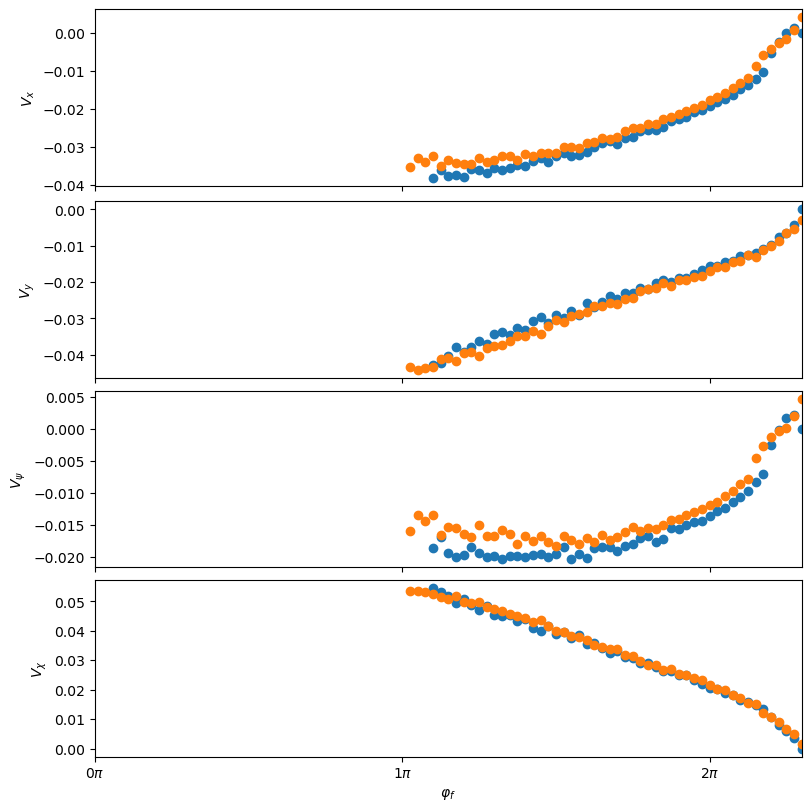

In [18]:
plot_Vfil_allt(FilamentList[0])

In [25]:
plot_V2r_V(s, FilamentList[0], dens, Te, Ti)


TypeError: 'Filament' object is not iterable

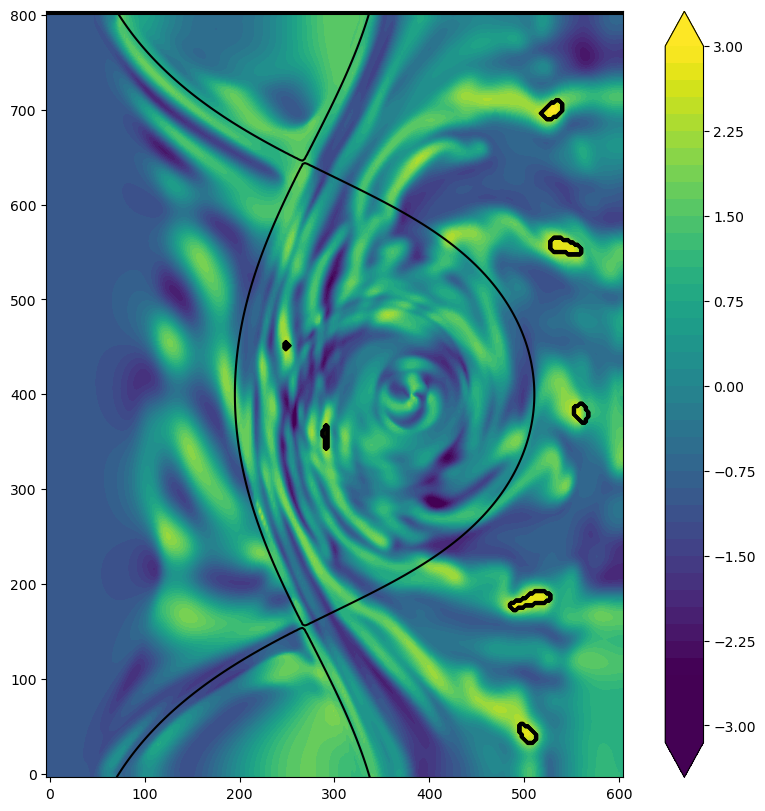

(<matplotlib.animation.FuncAnimation at 0x2b4de343fb50>,
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 1., 1., ..., 1., 1., 1.]]]))

In [11]:
plot_filamentlist2D(FilamentList, which_field='n', n_avg=dens_avg, n_std=dens_std, t1=t1, t2=t2, iz=0, color=0)